Wavelength range: 0.0 - 894.9 nm
Number of samples: 8
Data shape: (4096, 8)


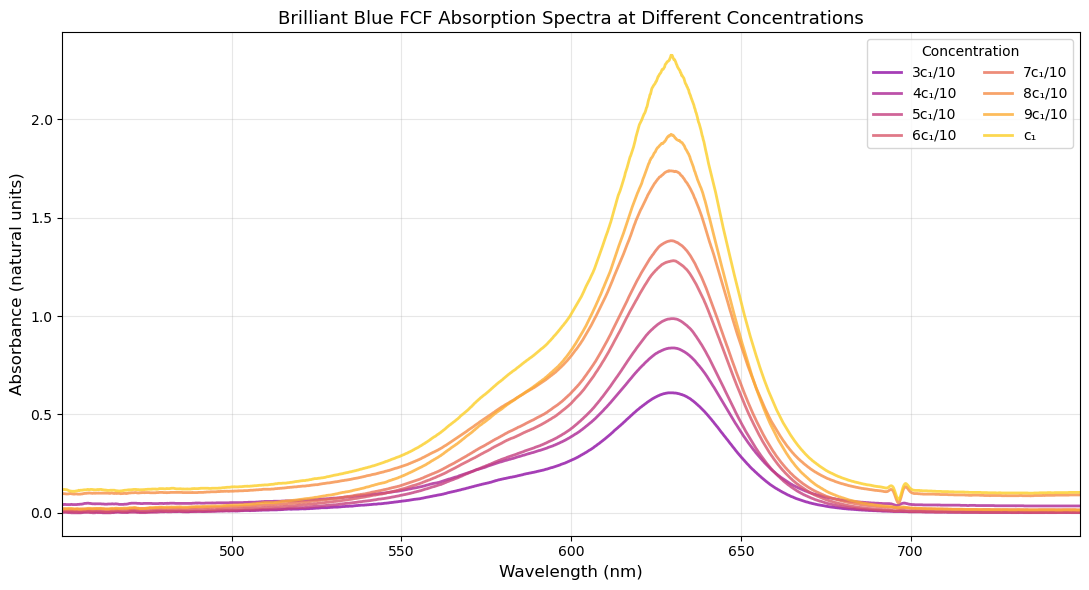

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats

# Load data from a CSV file
data = pd.read_csv('Data Low Concentration.csv')

# Extract wavelength and intensity data
wavelength = np.array(data['nm lambda'])
intensities = data.iloc[:, 1:].values

# Filter data for specific wavelengths
mask = (wavelength > 450) & (wavelength < 750)
wavelength_filtered = wavelength[mask]
intensities_filtered = intensities[mask, :]
sample_count = intensities_filtered.shape[1]

# Data overview
print(f"Wavelength range: {wavelength.min():.1f} - {wavelength.max():.1f} nm")
print(f"Number of samples: {sample_count}")
print(f"Data shape: {intensities.shape}")

# Define concentrations and labels
c1 = (3/32) * 0.000225137  # 1st solution - most concentrated
concentrations = np.array([3/10, 4/10, 5/10, 6/10, 7/10, 8/10, 9/10, 1]) * c1
labels = ['3c₁/10', '4c₁/10', '5c₁/10', '6c₁/10', '7c₁/10', '8c₁/10', '9c₁/10', 'c₁']

# Define figure and colors for plotting
plt.figure(figsize=(11, 6))
colors = plt.cm.plasma(np.linspace(0.3, 0.9, 8))

# plot the absorption spectra
for i in range(sample_count):
    plt.plot(wavelength_filtered, intensities_filtered[:, i], label=labels[i], color=colors[i], linewidth=2, alpha=0.8)
    
# Label the plots
plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('Absorbance (natural units)', fontsize=12)
plt.title('Brilliant Blue FCF Absorption Spectra at Different Concentrations', fontsize=13)
plt.legend(title='Concentration', ncol=2)
plt.grid(alpha=0.3)
plt.xlim(wavelength_filtered.min(), wavelength_filtered.max())
plt.tight_layout()

# Save figure
plt.savefig('Absorption Spectra.png', dpi=300)

Wavelength corresponding to peak index for most concentrated sample: 629.4 nm
Sample 1: Absorbance = 0.6100 at Wavelength = 629.4 nm
Sample 2: Absorbance = 0.8380 at Wavelength = 629.4 nm
Sample 3: Absorbance = 0.9870 at Wavelength = 629.4 nm
Sample 4: Absorbance = 1.2800 at Wavelength = 629.4 nm
Sample 5: Absorbance = 1.3830 at Wavelength = 629.4 nm
Sample 6: Absorbance = 1.7380 at Wavelength = 629.4 nm
Sample 7: Absorbance = 1.9240 at Wavelength = 629.4 nm
Sample 8: Absorbance = 2.3260 at Wavelength = 629.4 nm


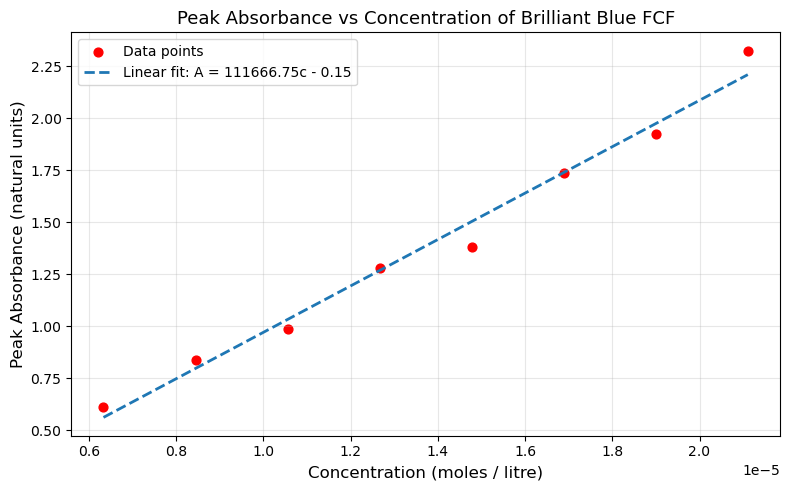

In [23]:
# Find index of the concentration sample's peak absorption
peak_index = intensities_filtered[:, 7].argmax()
print(f"Wavelength corresponding to peak index for most concentrated sample: {wavelength_filtered[peak_index]:.1f} nm")

# Find and store absorbances of all samples for the same wavelength as the most concentrated sample's peak
absorbances = []
for sample in range(sample_count):
    absorbance = intensities_filtered[:, sample][peak_index]
    absorbances.append(absorbance)

    print(f"Sample {sample + 1}: Absorbance = {absorbance:.4f} at Wavelength = {wavelength_filtered[peak_index]:.1f} nm")

# Plot peak absorption vs concentration
plt.figure(figsize=(8, 5))
plt.scatter(concentrations, absorbances, color='red', s=40, label='Data points')

# Perform linear regression and plot best fit line
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(concentrations, absorbances)
best_fit = slope * concentrations + intercept
plt.plot(concentrations, best_fit, linestyle='--', linewidth=2, label=f'Linear fit: A = {slope:.2f}c {"" if intercept >= 0 else "-"} {abs(intercept):.2f}')

# Plot labels and formatting
plt.xlabel('Concentration (moles / litre)', fontsize=12)
plt.ylabel('Peak Absorbance (natural units)', fontsize=12)
plt.title('Peak Absorbance vs Concentration of Brilliant Blue FCF', fontsize=13)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Save figure
plt.savefig('Peak Absorbance vs Concentration.png', dpi=300)
